In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [2]:
def filt(data,window_length=23, polyorder=2):
    """
    Function to low pass filter data to smooth out short-term
    fluctuations, using Savitzky–Golay filter 
    
    default settings quite harsh
    
    data : 
        timeseries of fluorescence, dff or f
    
    window_length : int
        the length of the filter window 
            (i.e. the number of coefficients)
            
    polyorder : int
        the order of the polynomial used to fit the samples. 
            polyorder must be less than window_length
    """
    
    from scipy.signal import savgol_filter
    fltData = savgol_filter(data, window_length, polyorder)
    return fltData

In [3]:
def findPeaks(data, thr, window=10):
    """
    Function to find peaks that are:
        further than "window" apart
        AND above threshold thr
        
    data : 
        1-dimensional timeseries to find peaks in
    
    thr : int
        threshold, to avoid spurious peaks
        
    window : int
        minimum number of samples peaks should be apart
    """
    downData = np.where(np.diff(data)<0)[0]    
    dInd = np.where(np.diff(downData)>window)[0] + 1
    peaks = downData[dInd]
    temp = np.where(data[peaks] < thr)[0]
    peaks = np.delete(peaks,temp)
    return peaks

In [4]:
def dff(data, window, percentile, downsample=1):

    """
    Estimate delta-f / f_baseline with the option to downsample

    data : 1D numpy array
       Data to be processed

    window : int
       Window size for baseline estimation. If downsampling is used, window will shrink proportionally

    percentile : int
       Percentile used as baseline

    downsample : int
       Rate of downsampling used before estimating baseline. For no downsampling, use downsample=1.
    """

    from scipy.signal import decimate
    from scipy.ndimage.filters import percentile_filter
    from numpy import interp

    if downsample == 1:
        baseline = percentile_filter(data, percentile=percentile, size=window)

    else:
        data_ds = decimate(data, downsample, ftype='iir', zero_phase=True)
        # using decimate with the default filter shifts the output by ~1-2% relative to the input.
        # correct for baseline shift by adding a small constant to data_ds
        data_ds += data.min() - data_ds.min()
        baseline_ds = percentile_filter(data_ds, percentile=percentile, size=window//downsample)
        baseline = interp(range(0, len(data)), range(0, len(data), downsample), baseline_ds)

    return (data - baseline) / baseline

In [5]:
def makeDff(data,win,perc,d=1):
    """
    function to plug t x timepoints timeseries into dff function
    (basically dff for multiple ROIs at once)
        
    """
    datDff = np.zeros(data.shape)
    for t in np.arange(0,data.shape[0]):
        datDff[t:] = dff(data[t],win,perc)
    return datDff

In [6]:
def getPeaks(datDff,val):
    """
    function to plug t x timepoints timeseries into findPeaks function
    (basically findPeaks for multiple ROIs at once)

    val : float, int
        multiplication factor of std of data that will determine 
        threshold for peak detection
        
    """
    peaks = []
    for t in np.arange(0,datDff.shape[0]):
        fltdff = filt(datDff[t])
        thr = val*(np.std(datDff[t]))
        peaks.append(findPeaks(fltdff, thr))
    return peaks

In [7]:
def keepWaves(a, jitter, midSeg, nSeg, tolerance):
    """
    function to keep elements from peak list in segment midSeg 
    that are also in neighbours ± jitter timesamples (to see 
    where multiple segments are active) and remove those that 
    are too close to one another, which means they are not sequential
    
    this function is quite ugly with all its for loops, but since
    we won't have huge datasets this is ok (does improve readability)
    
    a :
        peak list (result of getPeaks)

    jitter : int
        number of timesamples that defines the window in which neighbouring
        segments must be active to be counted as potential waves
        
    midSeg : int
        number of the segment that user sees is always involved in waves
    
    nSeg : int
        number segments that should also be active on either side of midSeg
        to count as waves
        
    tolerance : int
        samples midSeg and neighbours have to be apart to be counted as waves
        
    returns peaklist minus elements in midSeg that don't meet criteria for waves
        
    """
    s = []
    v = []

    for i in np.arange(midSeg-1, midSeg):
        t = []
        for j in np.arange(-jitter, jitter+1):
            t.append(np.isin(a[midSeg], a[i]+j))
        s.append(np.any(t,axis=0))           
            
# am having to divide into anterior and posterior of middle, because reasons
    for i in np.arange(midSeg+1, midSeg+nSeg):
        t = []
        for j in np.arange(-jitter, jitter+1):
            t.append(np.isin(a[midSeg], a[i]+j))
        s.append(np.any(t, axis=0))
            
# now remove elements that aren't really in sequence
    for i in np.arange(midSeg-1, midSeg+nSeg):
        u = []
        for el in a[midSeg]:
            if (np.abs(a[i] - el)).min() < tolerance:
                v.append(el)
    Inds = np.all(s, axis=0)
    a[midSeg] = a[midSeg][Inds]

    x, counts = np.unique(v, return_counts=True)
    delInds = np.isin(a[midSeg], x[counts>2], invert=True)
    a[midSeg] = a[midSeg][delInds]

    return a

In [8]:
def For_or_Bac(wavepeaks, jitter, midSeg):
    """
    function to see whether wave is forwards or backwards
    
    sees whether neighbouring segment's (midSeg - 1) peaks
    come before or after midSeg's peak
    
    returns:
        1 for forwards wave
        -1 for backwards wave
        0 if somehow it didn't make sense
        
    """
    forb = np.zeros(wavepeaks[midSeg].shape)
    c = -1
    for wave in wavepeaks[midSeg]:
        c+=1
        ant = wavepeaks[midSeg-1][np.searchsorted(wavepeaks[midSeg-1], wave, side='right')-1]
        if np.abs(wave - ant) > 0.5*wavepeaks[midSeg].max():
            """
            this is to catch edge effects
            """
            forb[c] = 1
        elif wave - ant > jitter:
            """
            is the previous anterior peak within the same wave or not?
            """
            forb[c] = 1
        elif wave - ant < jitter:
            forb[c] = -1
    return forb

In [9]:
def interSegTime(wavepeaks, fw_bw_inds, midSeg, jitter):
    """
    extract FW and BW indices; try to determine start and end of wave.
    tricky bit: variability in which segments they start.
    find mean peak in midSeg, then peaks in anterior segments before/after
    that peak for BW/FW waves, then peaks in posterior segments before/after
    that peak for BW/FW waves
    """
    i_f = []
    i_b = []
    mf = []
    ef = []
    mb = []
    eb = []
    
    indsF = wavepeaks[midSeg][np.where(fw_bw_inds==1)[0]]
    indsB = wavepeaks[midSeg][np.where(fw_bw_inds==-1)[0]]
    
    for t in np.arange(len(wavepeaks)):
        temp=[]
        for ind in indsF:
            if ind+plus < datDff_corr.shape[1]:
                temp.append(datDff_corr[t][ind-minus:ind+plus])
        mf.append(np.mean(temp, axis=0))
        ef.append(np.std(temp, axis=0))
    
    i_f = segOrder(mf, midSeg, direction='FW')
        
    for t in np.arange(len(wavepeaks)):
        temp=[]
        for ind in indsB:
            if ind+plus < datDff_corr.shape[1]:
                temp.append(datDff_corr[t][ind-minus:ind+plus])
        mb.append(np.mean(temp, axis=0))
        eb.append(np.std(temp, axis=0))
        
    i_b = segOrder(mb, midSeg, direction='BW')

    return np.diff(np.flip(i_f,0)), np.diff(i_b)

def segOrder(trace, midSeg, direction):
    """
    this is basically to catch segments with multiple peaks during jitter window, 
    and only select those either before or after depending on whether FW or BW wave
    """
    if direction=='BW':
        i=[]
        i_m = np.argwhere(trace[midSeg] == (trace[midSeg]).max())[0][0]
        [i.append(np.argwhere(trace[t][:i_m] ==(trace[t][:i_m]).max())[0][0]) for t in np.arange(0,midSeg)]
        i.append(i_m)
        [i.append(np.argwhere(trace[t][i_m:] ==(trace[t][i_m:]).max())[0][0]+i_m) for t in np.arange(midSeg+1,len(trace))]

    elif direction=='FW':
        i=[]
        i_m = np.argwhere(trace[midSeg] == (trace[midSeg]).max())[0][0]
        [i.append(np.argwhere(trace[t][i_m:] ==(trace[t][i_m:]).max())[0][0]+i_m) for t in np.arange(0,midSeg)]
        i.append(i_m)
        [i.append(np.argwhere(trace[t][:i_m] ==(trace[t][:i_m]).max())[0][0]) for t in np.arange(midSeg+1,len(trace))]
    else:
        print('No direction?')
    return i

In [10]:
# load data prepared earlier (eg timeseries of rois)

file = r'/Users/zwartm/Desktop/Jamie data/drug3.csv'
data = np.loadtxt(file, delimiter=',',skiprows=1).T
data = data[1:,:]

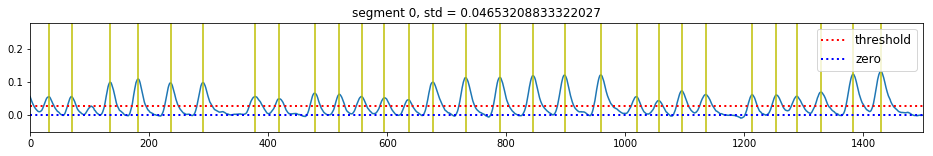

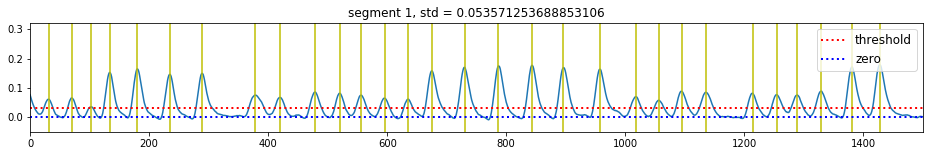

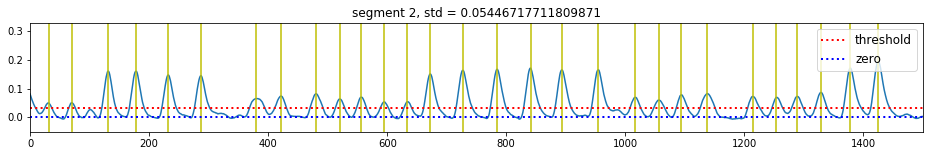

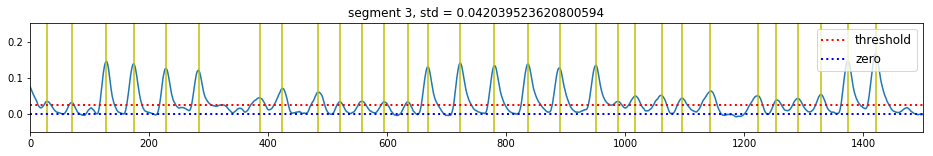

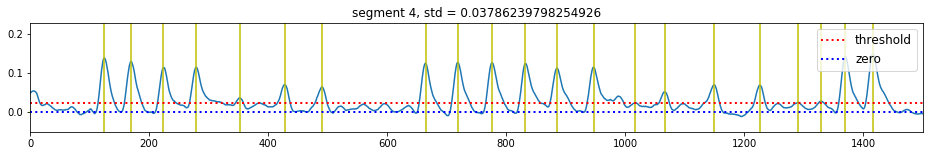

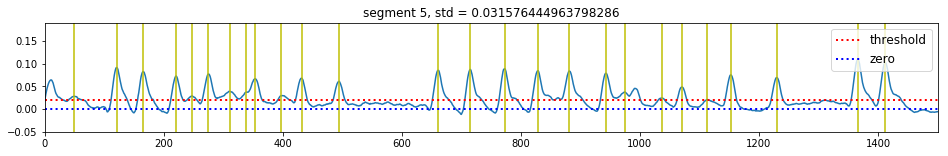

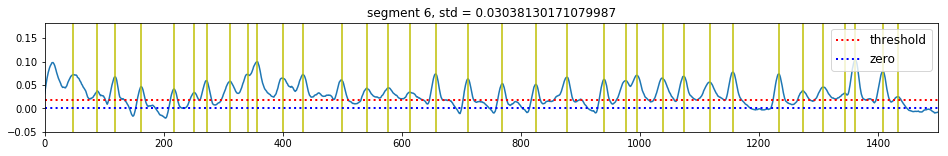

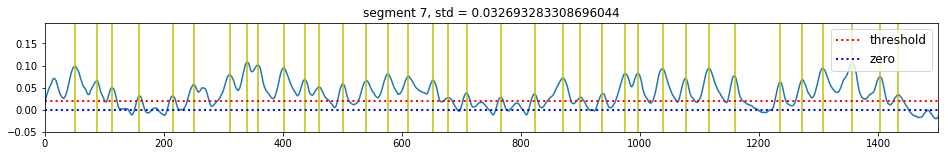

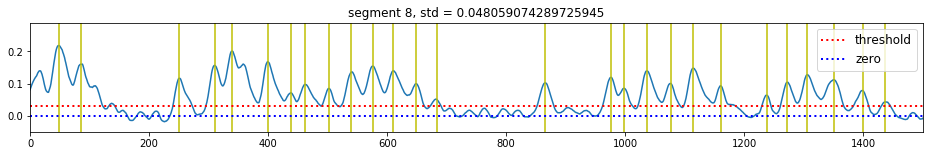

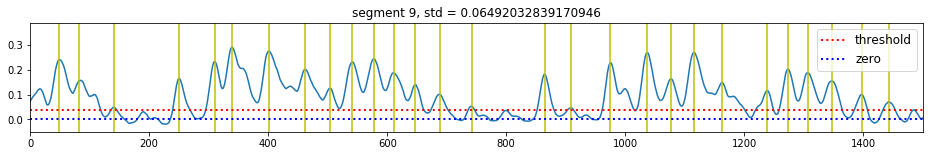

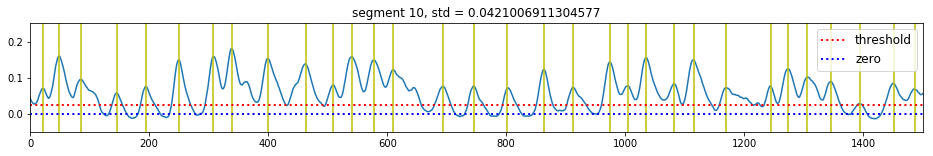

In [14]:
# get dff and find peaks; plot results
# change parameters if required

datDff = makeDff(data,500,10)
val=0.6
peaks = getPeaks(datDff, val)

for t in np.arange(0,datDff.shape[0]):
    
    plt.figure(t,figsize=(16,2))
    plt.title('segment '+ str(t) +', std = ' + str(np.std(datDff[t])))
    plt.plot(filt(datDff[t]))
    [plt.axvline(p,c='y') for p in peaks[t]]
    thr = val*(np.std(datDff[t]))
    plt.axhline(thr,linestyle=':', c='r', lw=2, label = 'threshold')

    plt.axhline(0,linestyle=':', c='b', lw=2, label = 'zero')
    plt.xlim(0,1500)
    plt.ylim(-0.05,6*(np.std(datDff[t])))
    plt.legend(fontsize=12, loc='upper right')
    

In [13]:
# Load kymograph prepared earlier

from skimage.external.tifffile import imread, imsave
dat = imread(tiffile)

/Users/zwartm/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [14]:
# detect waves, see whether forwards or backwards
# adjust these parameters as required

midSeg = 4
jitter = 18
tolerance = 2
nSeg = 2

waves = keepWaves(np.copy(peaks), jitter, midSeg, nSeg, tolerance)
d = For_or_Bac(waves, jitter, midSeg)

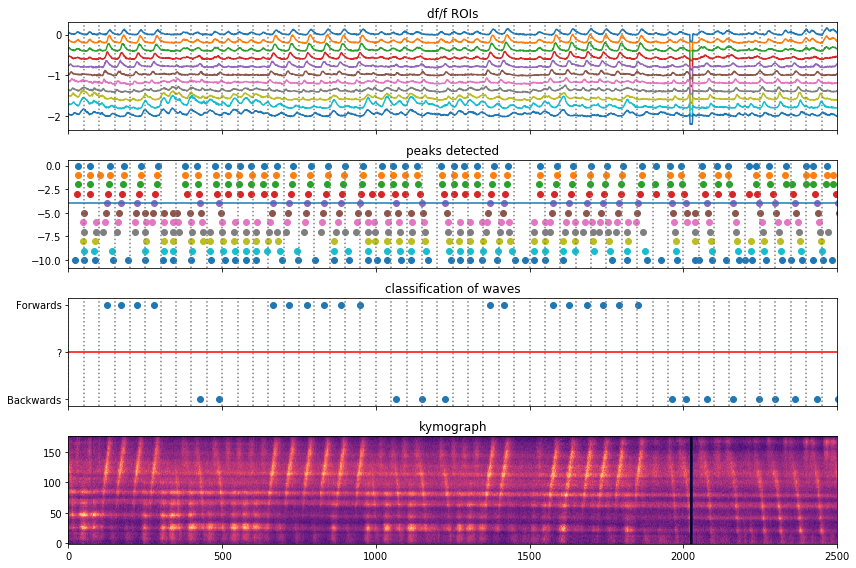

In [15]:
begin=0
end=2500

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex='all')
fig.set_size_inches(12,8)

[ax1.plot(datDff[t]-0.2*t)for t in np.arange(0,len(datDff))]
ax1.set_title('df/f ROIs')
[ax1.axvline(u, linestyle=':', c='0.5') for u in np.arange(0,end,50)]
ax1.set_xlim(begin,end)

[ax2.scatter(waves[t], np.ones(len(waves[t]))*-t)for t in np.arange(0, len(waves))]
ax2.set_title('peaks detected')
[ax2.axvline(u, linestyle=':', c='0.5') for u in np.arange(0,end,50)]
ax2.axhline(-midSeg)
ax2.set_xlim(begin,end)

ax3.scatter(waves[midSeg], d)
ax3.set_title('classification of waves')
[ax3.axvline(u, linestyle=':', c='0.5') for u in np.arange(0,end,50)]
ax3.axhline(0,c='r')
majorticks = [-1, 0, 1]
labels=['Backwards','?','Forwards']
ax3.set_yticks(majorticks, minor=False)
ax3.set_yticklabels(labels, minor=False)
ax3.set_xlim(begin,end)

ax4.imshow(dat[:,begin:end], origin='left', clim=([dat.min(),dat.max()]), cmap='magma', aspect='auto')
ax4.set_title('kymograph')
plt.tight_layout()
# plt.savefig(r'/Users/zwartm/Desktop/Jamie data/drug3_peaksetc.tif', dpi=100)
plt.show()


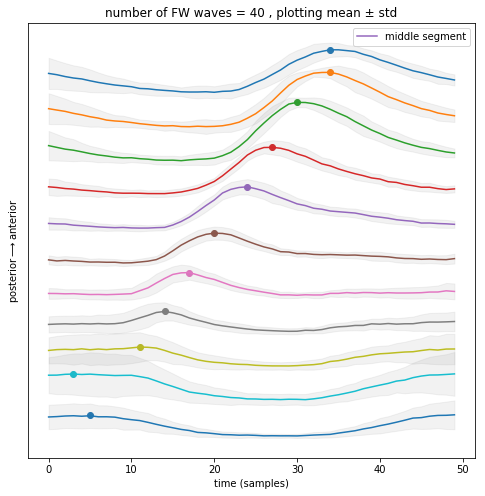

In [16]:
# plot trial-triggered averages for forwards waves

# first remove negative values during lights off (probably not universal, but this is fine)
datDff_corr = np.zeros(datDff.shape)
for t in np.arange(len(datDff)):
    datDff_corr[datDff>0] = datDff[datDff>0] 

# determine time window to plot (symmetric or not around midSeg peak)
minus = int(1.4*jitter)
plus = minus
inds = waves[midSeg][np.where(d==1)[0]]
m = []
e = []
te = []
for t in np.arange(len(waves)):
    temp=[]
    for ind in inds:
        if ind+plus < datDff_corr.shape[1]:
            temp.append(datDff_corr[t][ind-minus:ind+plus])
            te.append(datDff_corr[t][ind-minus:ind+plus])
    m.append(np.mean(temp, axis=0))
    e.append(np.std(temp, axis=0))

i_f_mid = np.argwhere(m[midSeg] ==(m[midSeg]).max())[0][0]
i_f=[]
for t in np.arange(0, midSeg):
    i_f.append(np.argwhere(m[t][i_f_mid:] ==(m[t][i_f_mid:]).max())[0][0]+i_f_mid)
i_f.append(i_f_mid)
for t in np.arange(midSeg+1, len(m)):
    i_f.append(np.argwhere(m[t][:i_f_mid] ==(m[t][:i_f_mid]).max())[0][0])

plt.figure(0,(8,8))
plt.title('number of FW waves = '+str(len(inds)) + ' , plotting mean ± std')
for t in np.arange(len(m)):
    if t == midSeg:
        plt.plot(m[t]-0.1*t, label = 'middle segment')
    else:
        plt.plot(m[t]-0.1*t)    
    ymax = max(m[t])
    plt.scatter(i_f[t],ymax-0.1*t)
    plt.fill_between(np.arange(0,minus+plus), (m[t]-0.1*t)-(e[t]), (m[t]-0.1*t)+(e[t]),color='0.5', alpha=0.1)
# plt.savefig(r'/Users/zwartm/Desktop/Jamie data/drug3_FWwaves.tif', dpi=100) 
plt.xlabel('time (samples)')
plt.text(-0.2*minus,-0.03*len(m),'posterior'+ r'$\longrightarrow$'+'anterior', rotation='90')
plt.yticks([])
plt.legend(loc='upper right')
plt.show()


In [18]:
datDff_corr.shape

(11, 6000)

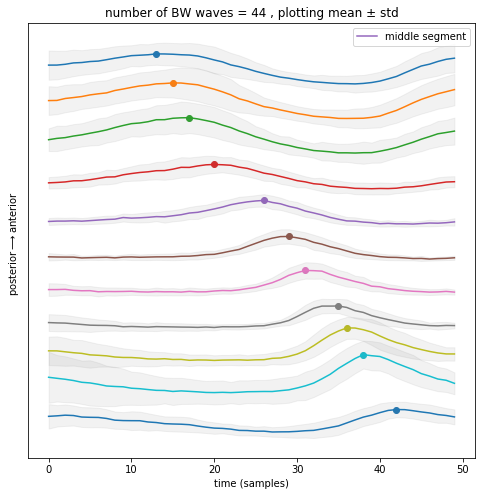

In [20]:
# plot trial-triggered averages for backwards waves

minus = int(1.4*jitter)
plus = minus
inds = waves[midSeg][np.where(d==-1)[0]]
m = []
e = []
te = []
for t in np.arange(len(waves)):
    temp=[]
    for ind in inds:
        if ind+plus < datDff_corr.shape[1]:
            temp.append(datDff_corr[t][ind-minus:ind+plus])
            te.append(datDff_corr[t][ind-minus:ind+plus])
    m.append(np.mean(temp, axis=0))
    e.append(np.std(temp, axis=0))

i_b_mid = np.argwhere(m[midSeg] ==(m[midSeg]).max())[0][0]
i_b=[]
for t in np.arange(0, midSeg):
    i_b.append(np.argwhere(m[t][:i_b_mid] ==(m[t][:i_b_mid]).max())[0][0])
i_b.append(i_b_mid)
for t in np.arange(midSeg+1, len(m)):
    i_b.append(np.argwhere(m[t][i_b_mid:] ==(m[t][i_b_mid:]).max())[0][0]+i_b_mid)

plt.figure(0,(8,8))
plt.title('number of BW waves = '+str(len(inds)) + ' , plotting mean ± std')
for t in np.arange(len(m)):
    if t == midSeg:
        plt.plot(m[t]-0.1*t, label = 'middle segment')
    else:
        plt.plot(m[t]-0.1*t)

    ymax = max(m[t])

    plt.scatter(i_b[t],ymax-0.1*t)
    plt.fill_between(np.arange(0,minus+plus), (m[t]-0.1*t)-(e[t]), (m[t]-0.1*t)+(e[t]),color='0.5', alpha=0.1)
# plt.savefig(r'/Users/zwartm/Desktop/Jamie data/drug3_BWwaves.tif', dpi=100) 
plt.xlabel('time (samples)')
plt.text(-0.2*minus,-0.03*len(m),'posterior'+ r'$\longrightarrow$'+'anterior', rotation='90')
plt.yticks([])
plt.legend(loc='upper right')
plt.show()


In [17]:
# calculate intersegmental travel time for forward (i_f) and backward (i_b)
i_f, i_b = interSegTime(waves,d, midSeg, jitter)

In [18]:
i_f

array([-2,  8,  3,  3,  3,  4,  3,  3,  4,  0])

In [19]:
i_b

array([2, 2, 3, 6, 3, 2, 4, 1, 2, 4])